In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install --upgrade kneed

In [ ]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

In [ ]:
#To download Dataset Kaggle Authenticatipn Details are Required
dataset_url = 'https://www.kaggle.com/datasets/wcukierski/enron-email-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./enron-email-dataset" (use force=True to force download)


In [ ]:
#REading Email Datasets
email = pd.read_csv('/content/enron-email-dataset/emails.csv')
email = email.sample(frac=1).reset_index(drop=True) # Shuffling Datasets Rows
email.shape

(517401, 2)

In [ ]:
# #Getting first 15K Records 
email = email.iloc[:15000]  
email.shape

(15000, 2)

In [ ]:
#Function that extracts these data into key-value pairs.
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email


def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

In [ ]:
email_df = pd.DataFrame(parse_into_emails(email.message))
email_df.head()

,body,to,from_
0,For your reading pleasure.I would add that I t...,Jude Rolfes/ENRON_DEVELOPMENT@ENRON_DEVELOPMEN...,kay.mann@enron.com
1,"Kay,I have an outline attached.....a bit of a ...","Rorschach, Reagan; Fairley, David","Mann, Kay"
2,Can you check this deal with Pacific Gas and E...,kate.symes@enron.com,rhonda.denton@enron.com
3,please revise - thanks.-----Original Message--...,"Barbe, Robin; Chilkina, Elena; Dicarlo, Louis;...","Shackleton, Sara"
4,Debelah Morgan! She is really big in the Hip ...,gerald.nemec@enron.com,bswaldrop@aol.com


In [ ]:
#Dropping null Rows
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)
email_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14267 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    14267 non-null  object
 1   to      14267 non-null  object
 2   from_   14267 non-null  object
dtypes: object(3)
memory usage: 445.8+ KB


In [ ]:
#Generating TF-IDF
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(email_df.body)

In [ ]:
# Find out what the top keywords were in those emails
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

   features     score
0    reagan  0.308527
1   fairley  0.202437
2       kay  0.199697
3   outline  0.194328
4     stuff  0.173191
5     think  0.151164
6  fromthem  0.148454
7   justhad  0.148454
8   bemoved  0.143942
9    amalso  0.140443


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Function to get the top terms out of all the emails.
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:
#Returning the top terms out of all the emails.
print(top_mean_feats(X, features, top_n=10))


   features     score
0       com  0.079696
1     enron  0.076960
2       ect  0.023318
3       hou  0.013041
4   message  0.011817
5  original  0.010619
6    thanks  0.008564
7      mail  0.006933
8       713  0.006858
9       doc  0.006276


## Clustering with KMeans


In [ ]:
#Clustering with KMeans

from sklearn.cluster import KMeans
n_clusters = 5
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

In [ ]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

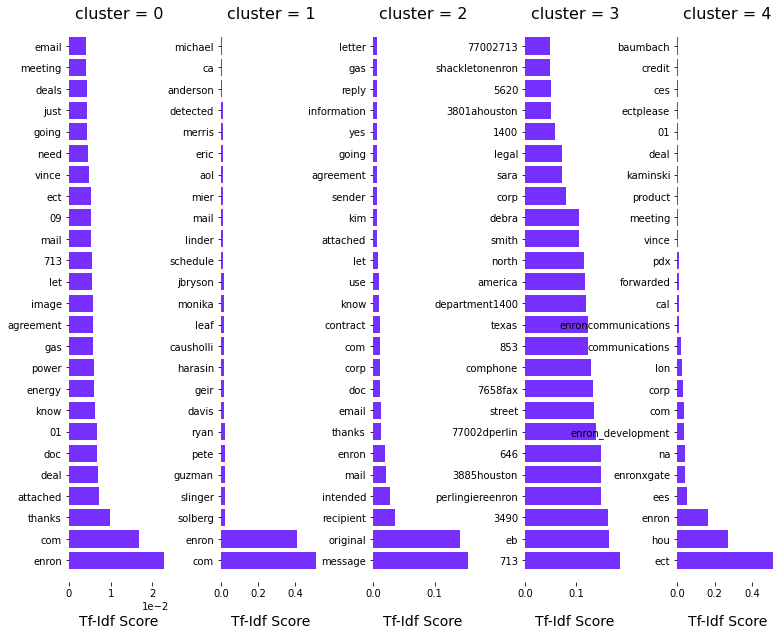

In [ ]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


### Finding Number of Clusters by Knee Elbow Method

In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [ ]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X)
  sse.append(kmeans.inertia_)

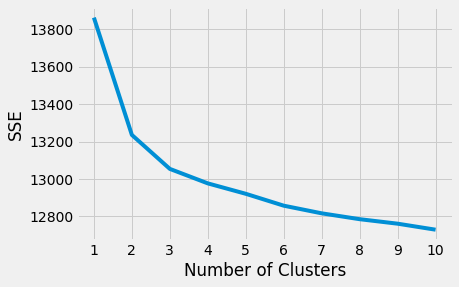

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

## By Elbow Method, 3 Clusturs are the Best Fit For Our Email Data

In [ ]:
from sklearn.cluster import KMeans
n_clusters = kl.elbow
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='random', n_init=1)
labels = clf.fit_predict(X)

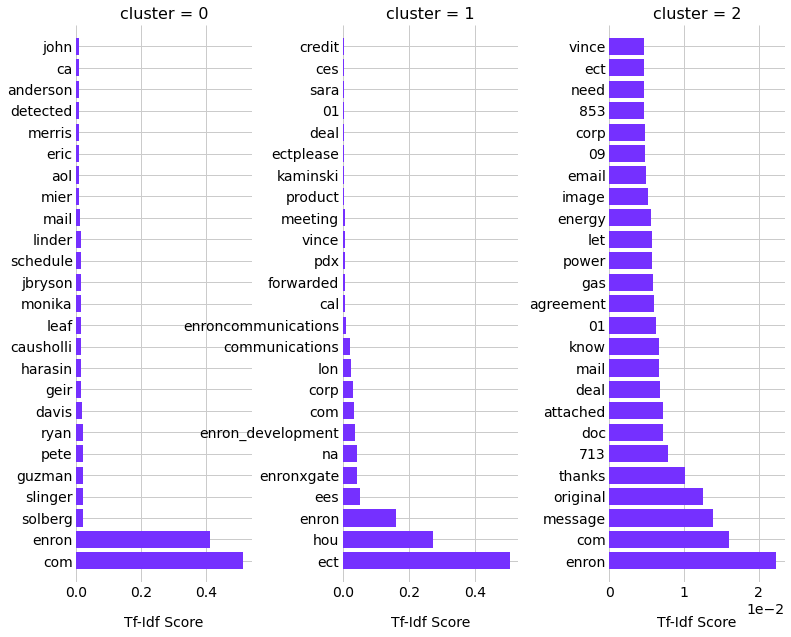

In [ ]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [ ]:
email_df['Labels'] = labels
email_df.head()

,body,to,from_,Labels
0,For your reading pleasure.I would add that I t...,Jude Rolfes/ENRON_DEVELOPMENT@ENRON_DEVELOPMEN...,kay.mann@enron.com,2
1,"Kay,I have an outline attached.....a bit of a ...","Rorschach, Reagan; Fairley, David","Mann, Kay",2
2,Can you check this deal with Pacific Gas and E...,kate.symes@enron.com,rhonda.denton@enron.com,2
3,please revise - thanks.-----Original Message--...,"Barbe, Robin; Chilkina, Elena; Dicarlo, Louis;...","Shackleton, Sara",2
4,Debelah Morgan! She is really big in the Hip ...,gerald.nemec@enron.com,bswaldrop@aol.com,2


In [ ]:
email_df.shape

(14267, 4)

In [ ]:
email_df['Labels'].unique()


array([2, 0, 1], dtype=int32)

In [ ]:
email_df.to_csv('out.csv', index = False)